# Overview Analysis
In this notebook I investigate the overall trends in the data and identify areas worth exploring further

## Table of Contents
- [Data Preparation](#Data-Preparation)
- [Dataset Details](#Dataset-Details)
- [Overall Age Distribution](#Overall-Age-Distribution)
- [Normalised Age Distribution](#Normalised-Age-Distribution)
- [Areas for further investigation](#Areas-for-further-investigation)

# Data-Preparation

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import DataCleaner

In [13]:
%matplotlib inline
pd.set_option('display.max_rows', None) # Display full dataframe tables
pd.set_option('display.max_columns', None)

In [14]:
# Read in data
athlete_events_df=pd.read_csv("data/athlete_events.csv")
noc_regions_df=pd.read_csv("data/noc_regions.csv",index_col="NOC")

In [15]:
# Clean data (See DataCleaner.py for details)
athlete_df=DataCleaner.clean_athlete_events(athlete_events_df)
noc_df=DataCleaner.clean_noc_regions(noc_regions_df)

In [16]:
# Add Field
athlete_df["Medalist"]=athlete_df["Medal"].isin(["gold","silver","bronze"]) # boolean for whether athlete won a medal
athlete_df["Birth_Year"]=athlete_df["Year"]-athlete_df["Age"]

In [17]:
athlete_df.head()

,Athlete_ID,Name,Sex,Age,NOC,Year,Season,Sport,Event,Medal,Medalist,Birth_Year
1,2,a lamusi,M,23.0,chn,2012,summer,judo,extra-lightweight,NaN,False,1989.0
4,5,christine jacoba aaftink,F,21.0,ned,1988,winter,speed skating,500 metres,NaN,False,1967.0
5,5,christine jacoba aaftink,F,21.0,ned,1988,winter,speed skating,"1,000 metres",NaN,False,1967.0
6,5,christine jacoba aaftink,F,25.0,ned,1992,winter,speed skating,500 metres,NaN,False,1967.0
7,5,christine jacoba aaftink,F,25.0,ned,1992,winter,speed skating,"1,000 metres",NaN,False,1967.0


# Dataset Details

In [18]:
print("'athlete_df' contains {:,} rows covering:".format(athlete_df.shape[0]))
summer_games=athlete_df[athlete_df["Season"]=="summer"]
winter_games=athlete_df[athlete_df["Season"]=="winter"]
print("\t{} summer games ({}-{}) & {} winter games ({}-{}).".format(len(summer_games["Year"].unique()),summer_games["Year"].min(),summer_games["Year"].max(),len(winter_games["Year"].unique()),winter_games["Year"].min(),winter_games["Year"].max()))
print("\t{} sports ({} summer, {} winter).".format(len(athlete_df["Sport"].unique()),len(athlete_df[athlete_df["Season"]=="summer"]["Sport"].unique()),len(athlete_df[athlete_df["Season"]=="winter"]["Sport"].unique())))

both_games_sports=list(set(athlete_df[athlete_df["Season"]=="summer"]["Sport"].unique()) & set(athlete_df[athlete_df["Season"]=="winter"]["Sport"].unique()))
print("\t{} sport{} {} appeared in both the winter & summer games ({})".format(len(both_games_sports),"" if len(both_games_sports)==1 else "s","has" if len(both_games_sports)==1 else "have",",".join(both_games_sports)))
print("\t{} events ({} summer, {} winter).\n".format(len(athlete_df["Event"].unique()),len(athlete_df[athlete_df["Season"]=="summer"]["Event"].unique()),len(athlete_df[athlete_df["Season"]=="winter"]["Event"].unique())))


'athlete_df' contains 200,969 rows covering:
	18 summer games (1948-2016) & 18 winter games (1948-2014).
	41 sports (27 summer, 14 winter).
	0 sports have appeared in both the winter & summer games ()
	278 events (221 summer, 67 winter).



# Overall Age Distribution

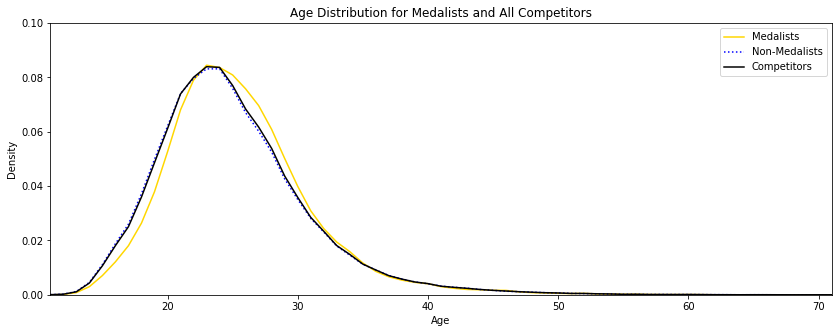

In [29]:
fig,axes=plt.subplots(figsize=(14,5),nrows=1,ncols=1)
# kde plot of age distribution for medal winners against non-winners
# suggests medal winners are slightly older
xlims=(athlete_df["Age"].min(),athlete_df["Age"].max())
ylims=(0,.1)
eval_points=[i for i in range(int(xlims[0]),int(xlims[1])+1)] # estimate distribution at each year

# Plot data for all athletes
athlete_df[athlete_df["Medalist"]]["Age"].plot.kde(ind=eval_points,xlim=xlims,ylim=ylims,label="Medalists",color="gold",ax=axes)
athlete_df[~athlete_df["Medalist"]]["Age"].plot.kde(ind=eval_points,xlim=xlims,ylim=ylims,label="Non-Medalists",color="blue",ls=":",ax=axes)
athlete_df["Age"].plot.kde(ind=eval_points,xlim=xlims,ylim=ylims,label="Competitors",color="black",ax=axes)
axes.set_title("Age Distribution for Medalists and All Competitors")
axes.set_xlabel("Age")
axes.legend()

This plot offers up nothing surprising. Most competitors are in their 20s and medalists are likely to be a bit older than their other competitors, likely due to greater experience.\
I shall now consider when an athlete was born in the olympic cycle.

# Normalised Age Distribution

In [20]:
# Determine how many years after an olympics an athlete was born
# This is complicated by the fact that the summer & winter games were in sync until 1994
summer_athletes=(athlete_df["Season"]=="summer")
pre_change_winter_athletes=((athlete_df["Season"]=="winter") & (athlete_df["Birth_Year"]<1994))
post_change_winter_athletes=((athlete_df["Season"]=="winter") & (athlete_df["Birth_Year"]>=1994))

athlete_df.loc[summer_athletes,"Cycle_Age"]=(athlete_df.loc[summer_athletes,"Birth_Year"]%4)
athlete_df.loc[pre_change_winter_athletes,"Cycle_Age"]=(athlete_df.loc[pre_change_winter_athletes,"Birth_Year"]%4)
athlete_df.loc[post_change_winter_athletes,"Cycle_Age"]=((athlete_df.loc[post_change_winter_athletes,"Birth_Year"]-2)%4)

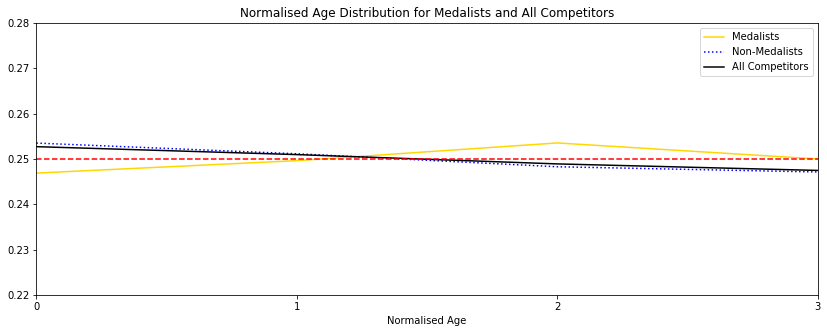

In [27]:
medalists=athlete_df[athlete_df["Medalist"]]["Cycle_Age"].value_counts(normalize=True).sort_index()
non_medalists=athlete_df[~athlete_df["Medalist"]]["Cycle_Age"].value_counts(normalize=True).sort_index()
competitors=athlete_df["Cycle_Age"].value_counts(normalize=True).sort_index()

fig,axes=plt.subplots(figsize=(14,5),nrows=1,ncols=1)
# kde plot of age distribution for medal winners against non-winners
# suggests medal winners are slightly older
xlims=(0,3)
x_tick_labels=range(0,4)
ylims=(.22,.28)
y_tick_labels=[x/100 for x in range(int(100*ylims[0]),int(100*ylims[1])+1,1)]

# Plot data for all athletes
medalists.plot(ax=axes,ylim=ylims,xlim=xlims,label="Medalists",c="gold")
non_medalists.plot(ax=axes,ylim=ylims,xlim=xlims,label="Non-Medalists",c="blue",ls=":")
competitors.plot(ax=axes,ylim=ylims,xlim=xlims,label="All Competitors",c="black")
axes.set_title("Normalised Age Distribution for Medalists and All Competitors")
axes.axhline(.25,color="red",ls="--")
axes.set_xlabel("Normalised Age")
axes.set_xticks(x_tick_labels)
axes.set_yticks(y_tick_labels)
axes.legend()

This plots suggests that more olympic athletes are born in an Olympic year, than expected, and less medalists are born than expected.\
The plot suggests that the chance of being an olympic athlete decreases the longer after an olympiad you are born.\
Of course the discrepancies are very small here so I shall now use statistical techniques to determine wethere these results are significant or not.

## Statistical Signifance

In [ ]:
# TODO hypothesis tests on conclusion drawn from previous plot

# Areas for further investigation
Split by:
- Gender
- Winter or Summer Games
- Sport